# Frecuencias de términos y géneros en corpus

Una forma de visualizar la distribución de los datos en el corpus es ver cómo se distribuyen los géneros en éste.
Para esto, presentamos algunas estadísticas sencillas sobre términos y géneros.

In [1]:
from glob import glob
from re import compile
from collections import defaultdict, Counter
from itertools import chain
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

### Preparación del corpus

#### Tokenización

La tokenización es un proceso esencial del pre-procesamiento del corpus. Definimos una función de tokenización que realiza los siguientes pasos:

* Pasa el texto a minúsculas.
* Elimina símbolos ortográficos.
* Separa los tokens por espacios.

In [2]:
#Símbolos ortográficos
regex = compile('[-_{}(),;:"#\/.¡!¿?·]')

def tokenize(text):
    """
    Función simple de tokenización por espacios en blanco.
    
    Arguments
    ---------
    text : documentos
        Lista de documentos que se van a tokenizar.
        
    Returns
    -------
    tokens 
        La lista de los documentos tokenizada.
    """
    #Elimina \n de más
    #Pasa todo a minúscula
    lower_text = text.strip().lower()
    #Elimina los símbolos ortográficos
    alphanumeric = regex.sub('', lower_text)
    #Separa por espacios en blanco
    tokens = alphanumeric.split()
    
    return tokens

##### Carga del corpus

Utilizamos un pequeño corpus de entradas de la Wikipedia, leemos archivo por archivo indicando el directorio en donde se encuentran los documentos.

In [3]:
#Directorio de los documentos
directory = 'wikipedia/'

#Guarda diccionario {documento:tokens}
tokens = {}
for filename in glob(directory+'*'):
    #Lee los documentos
    text = open(filename,'r').read()
    #tokeniza los documentos
    tokenized_text = tokenize(text)
    #Guarda documentos en diccionario
    tokens[filename] = tokenized_text

##### Genera tópicos y sus tokens

En este caso, los nombres de los documentos contienen los tópicos a los que pertenecen, por lo que usamos estos nombres para guardar los documentos.

Cada documentos es de la forma:

$$\text{wikipedia/topico (n).txt}$$

En este caso sólo nos quedamos con la información en 'topico' que nos indica el género o tópico al que pertenece. Por cada tópico obtenemos sus tokens.

In [4]:
#Diccionario de tópicos y tokens
topics = defaultdict(list)

for fname, token_list in tokens.items():
    #Tomamos la información del nombre del 
    #documento que corresponde al tópico al que pertenece.
    topic_name = fname[10:][:-8]
    #Por cada tópico agregamos la lista de tokens
    topics[topic_name].append(token_list)

Obtenemos la frecuencia absoluta del término, así como las frecuencias $f_{ij}$ del término $i$ en el tópico $j$.

In [5]:
#Frecuencia absoluta de términos
term_frequency = Counter(chain(*chain(*topics.values())))

#Frecuencias del termino i en el tópico j
topic_frequency = {g: Counter(chain(*token_list)) for g, token_list in topics.items()}

Observamos las palabras más frecuentes y las menos frecuentes:

In [6]:
#Visualización con pandas
AbsFreq = pd.DataFrame({term: [f] for term, f in term_frequency.items()}).T
AbsFreq.sort_values(by=0, ascending=False)

,0
de,7454
la,4737
en,3130
y,2726
el,2643
...,...
judicial,1
autorizadas,1
profeta,1
seqüi,1


#### Tamaño del género

El tamaño del género $j$ lo obtenemos como:

$$r_j = \frac{\sum_i f_{ij}}{\sum_i t_i}$$
Aquí $t_i$ es la frecuencia absoluta del término i.

In [7]:
#Suma de las frecuencias absolutas de los términos
total_term_freq = sum(term_frequency.values())

#Diccionario de tamaños de tópicos
topic_size =  {}
for topic, types in topic_frequency.items():
    #Suma de frecuencias de términos en tópicos
    freq_topic_j = sum(types.values())
    #Tamaño reativo del género
    r_j = freq_topic_j/total_term_freq
    #Guardamos en el diccionario.
    topic_size[topic] = r_j

El tamaño relativo del género nos puede dar información de qué tópicos contiene el corpus y cómo están representados estos. Es una medida de gran utilidad para poder balancear los corpus y obtener datos que representen adecuadamente cada uno de los contenidos de éste.

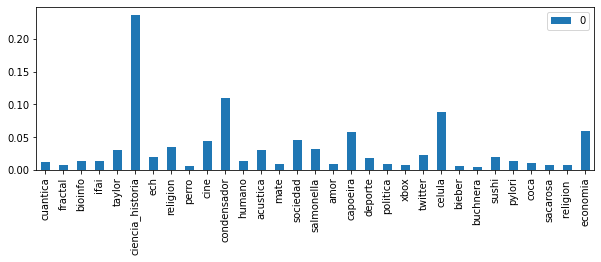

In [8]:
#Visualización con pandas
pd.DataFrame({topic:[size] for topic, size in topic_size.items()}).T.plot.bar(figsize=(10,3))
plt.show()

#### Frecuencia corregida

A partir del tamaño de los géneros podemos calcular la frecuencia corregida de los términos que nos da una idea de cómo los términos se distribuyen a partir de los géneros y en el corpus.

Esta se calcula como:

$$KF_i = \Big(\sum_j \sqrt{r_j f_{ij}} \Big)^2$$

In [9]:
#Diccionario de frecuencias corregidas
corr_freq = {}
for term in term_frequency.keys():
    #Acumula los valores ponderados
    values = 0
    for topic, topic_term_freq in topic_frequency.items():
        #Suma el cuadrado de los valores ponderados r_j*f_ij
        values += np.sqrt(topic_size[topic]*topic_term_freq[term])
    #Eleva al cuadrado y guarda
    corr_freq[term] = values**2

In [10]:
KF = pd.DataFrame({term: [kf] for term, kf in corr_freq.items()}).T
KF.sort_values(by=0, ascending=False)

,0
de,7416.162435
la,4635.940860
en,3082.431877
y,2677.544799
el,2600.668091
...,...
maternal,0.004386
coespecializción,0.004386
bacteriocitas,0.004386
hospedan,0.004386


In [11]:
print(KF.loc['historia'],'\n',AbsFreq.loc['historia'])

0    55.0664
Name: historia, dtype: float64 
 0    102
Name: historia, dtype: int64
